# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
from decimal import Decimal
import random

# Get weight values

In [2]:
total_num_of_weight = 401
def get_weights_arr():
    weights_arr = []
    w_val = Decimal('-2.0')
    step = Decimal('0.01')
    for i in range (total_num_of_weight):
        weights_arr.append(float(w_val))
        w_val += step
    return weights_arr

weights_arr = get_weights_arr()
#the weight value to be recovered
true_weight = 1.43

# Function Definitions

In [3]:
def float_to_binary_str(f):
    # Pack the float into 4 bytes (32-bit) using IEEE 754 standard
    [packed] = struct.unpack('!I', struct.pack('!f', f))
    # Convert the packed number to a binary string
    return f"{packed:032b}"

In [4]:
def HW_float32(f):
    # Get the binary representation of the 32-bit float
    binary_str = float_to_binary_str(f)
    # Count and return the number of '1' bits
    return binary_str.count('1')

In [5]:
#get one part of the binary representation
def getbyte(f,byte_position):
    if byte_position == 0:#sign bit
        inbinary = float_to_binary_str(f)[0]
    elif byte_position == 4:#last 7 bits
        inbinary = float_to_binary_str(f)[25:32]
    else:
        inbinary = float_to_binary_str(f)[(byte_position-1)*8+1:byte_position*8+1]
    
    return int(inbinary,2)

#### The values to be recovered

In [6]:
#true values of different parts of the weight
def get_true_values():
    
    true_values = []
    for i in range(5):
        true_values.append(getbyte(true_weight,i))
    return true_values

true_values = get_true_values()
true_index = weights_arr.index(true_weight)

In [7]:
print("sign bit = " + str(true_values[0]) + 
      ", exponent = " + str(true_values[1]) + 
      ", first mantissa byte = " + str(true_values[2]) + 
      ", second mantissa byte = " + str(true_values[3]) + 
      ", last 7 bits = " + str(true_values[4]))

sign bit = 0, exponent = 127, first mantissa byte = 110, second mantissa byte = 20, last 7 bits = 61


In [8]:
def get_hypothetical_leakages(num_of_traces, inputs_arr):
    hypothetical_leakages = [[] for i in range(total_num_of_weight)]
    for weight_index in range(total_num_of_weight):
        for j in range(num_of_traces):
            #compute the hypothetical product values for each hypothetical value of weight and each random input
            hypothetical_product = weights_arr[weight_index] * inputs_arr[j]
            #compute hypothetical leakages
            hypothetical_leakages[weight_index].append(HW_float32(hypothetical_product))
    return np.array(hypothetical_leakages)

In [9]:
def plot_GE(ge, trace_nums):
    x = []
    
    for num in trace_nums:
        x.append(num)
    
    for i in range(5):
        plt.plot(x, ge[i], label=str(i))
        plt.legend(loc="upper left")

    return

In [10]:
def savefile(foldername, filename, ge, trace_nums):
    f = open(foldername + "//" + filename + ".txt", "w")
    cols = 5#number of columns
    rows = len(trace_nums)#number of rows/x axis values
    
    
    #first line
    f.write("x ")
    for i in range(cols):
        f.write("y"+str(i)+" ")
    f.write("\n")
    
    for i in range(rows):#for each line
        f.write(str(trace_nums[i])+" ")#first write down the trace number considered
        for j in range(cols):
            f.write(str(ge[j][i])+" ")
        f.write("\n")
    f.close()
    return

In [11]:
def load_traces(num_of_traces, folder_name):
    trace_waves_arr = []
    inputs_arr = []

    for i in range(num_of_traces):
        with open(folder_name + '/trace_'+str(i)+'.txt') as f:
            lines = f.read().splitlines()
            trace_waves_arr.append(lines)

    with open(folder_name + '/inputs.txt') as f:
        inputs_arr = f.read().splitlines()
    trace_waves_arr = np.array(trace_waves_arr)
    trace_waves_arr = trace_waves_arr.astype(float)

    inputs_arr = np.array(inputs_arr)
    inputs_arr = inputs_arr.astype(float)
    return trace_waves_arr, inputs_arr

In [12]:
#compute rank of the correc weight
def get_rank(trace, hypothetical_leakages, total_time_sample, start_time_sample):
    #r records the maximum absolute correaltions for each value of each part of the weight
    r = [[0 for j in range(256)] for i in range(5)]
    
    
    for t in range(total_time_sample):#for each time sample
        time_sample_index = t + start_time_sample
        for weight_index in range(total_num_of_weight):#for each possible weight value
            cor = np.corrcoef(hypothetical_leakages[weight_index],trace[:,time_sample_index])[0][1]
            cor = abs(cor)
            for position in range(5):#compute the sign bit, exponent and mantissa of this weight
                part_value = getbyte(weights_arr[weight_index],position)
                if r[position][part_value] < cor:
                    r[position][part_value] = cor#update the absolute correlation with the maximum value

#     r = np.array(r)
    ##get rank of key
# There are 10 distinct exponent bits
# There are 100 distinct first byte of mantissa
# There are 25 distinct second byte of mantissa
# There are 25 distinct last 7 bits
    rank = [0,0,0,0,0]
    for i in range(5):
        corr_correct = r[i][true_values[i]]
        r[i].sort()
        ind = r[i].index(corr_correct)
        rank[i] = 256 - ind
    return rank

In [13]:
def GE(trace, hypothetical_leakages, trace_nums, no_of_attack, total_num_of_traces, total_time_sample, start_time_sample):
    num_of_cases = len(trace_nums)
    GE = [[0 for j in range(num_of_cases)] for i in range(5)]
    
    for j in range(num_of_cases):#for each number of traces to consider
        num = trace_nums[j]
        print("computing for number of traces: " + str(num))
        #take a random set of traces
        indall = random.sample(range(total_num_of_traces), num*no_of_attack)
        for i in range(no_of_attack):#repeat no_of_attack experiments
            #each attack uses a different set of traces
            ind = indall[i*num:(i+1)*num]
            trace_subset = trace[ind]#take the set of traces for this attack
            leakages_subset = hypothetical_leakages[:,ind]#extract the corresponding hypothetical leakages
            r = get_rank(trace_subset, leakages_subset, total_time_sample, start_time_sample)
            for position in range(5):#add rank for each part of the weight
                GE[position][j] += r[position]
                
        for position in range(5):#take the average
            GE[position][j] /= no_of_attack
    plot_GE(GE, trace_nums)
    return GE
            

# Computation of GE for unprotected implementations

In [14]:
traces, inputs = load_traces(num_of_traces=2000, folder_name="unprotected")

In [15]:
start = 490
end = 1011
total = end - start

In [16]:
#first compute all hypothetical leakages
hypothetical_leakages_unprotected = get_hypothetical_leakages(num_of_traces=2000, inputs_arr=inputs)

In [17]:
trace_nums = [i for i in range(10,200,10)]

computing for number of traces: 10
computing for number of traces: 20
computing for number of traces: 30
computing for number of traces: 40
computing for number of traces: 50
computing for number of traces: 60
computing for number of traces: 70
computing for number of traces: 80
computing for number of traces: 90
computing for number of traces: 100
computing for number of traces: 110
computing for number of traces: 120
computing for number of traces: 130
computing for number of traces: 140
computing for number of traces: 150
computing for number of traces: 160
computing for number of traces: 170
computing for number of traces: 180
computing for number of traces: 190


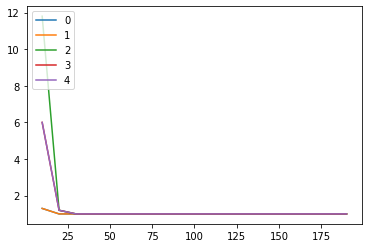

In [18]:
GE_unprotected = GE(traces, hypothetical_leakages_unprotected, trace_nums, 
   no_of_attack=10, total_num_of_traces=2000, 
   total_time_sample=total, start_time_sample=start)

In [19]:
print(GE_unprotected)

[[1.3, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.3, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [11.8, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [6.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [6.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


In [20]:
savefile("GE", "GE_unprotected", GE_unprotected, trace_nums)

# Computation of GE for protected implementations

In [21]:
traces_pro, inputs_pro = load_traces(num_of_traces=10000, folder_name="protected")

In [22]:
start = 490
end_pro = 4301
total_pro = end_pro - start

In [23]:
#first compute all hypothetical leakages
hypothetical_leakages = get_hypothetical_leakages(num_of_traces=10000, inputs_arr=inputs_pro)

In [24]:
trace_nums_pro = [10, 15, 20, 30]

computing for number of traces: 10
computing for number of traces: 15
computing for number of traces: 20
computing for number of traces: 30


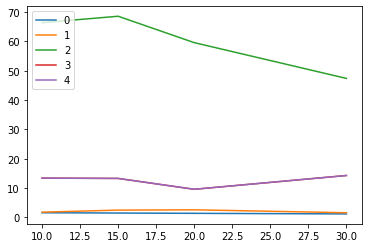

In [25]:
GE_protected = GE(traces_pro, hypothetical_leakages, trace_nums_pro, 
   no_of_attack=10, total_num_of_traces=10000, 
   total_time_sample=total_pro, start_time_sample=start)

In [26]:
print(GE_protected)

[[1.6, 1.5, 1.4, 1.2], [1.8, 2.5, 2.6, 1.6], [66.4, 68.6, 59.6, 47.4], [13.4, 13.3, 9.6, 14.3], [13.4, 13.3, 9.6, 14.3]]


In [27]:
savefile("GE", "GE_protected", GE_protected, trace_nums_pro)

In [28]:
# 2 sign bits
# 10 distinct exponent bits
# 100 distinct first byte of mantissa
# 25 distinct second byte of mantissa
# 25 distinct last 7 bits